In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Disable GPU

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.flatten_util import ravel_pytree

import optax
# import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter, set_default_jitter, set_positive_bijector, get_default_jitter
from gpax.models import ExactGPRegression, SparseGPRegression, LatentGPHeinonen, LatentGPDeltaInducing
from gpax.kernels import RBF, Gibbs
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian, Heteroscedastic
from gpax.utils import train_fn, DataScaler, add_to_diagonal
from gpax.plotting import plot_posterior
from scipy.io import loadmat, savemat
from sklearn.preprocessing import MinMaxScaler

import tensorflow_probability.substrates.jax as tfp
tfb = tfp.bijectors

import regdata as rd
from tqdm import trange

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)
set_positive_bijector(tfb.Exp())
print(get_default_jitter())

def assert_same_pytree(tree1, tree2):
    assert jtu.tree_structure(tree1) == jtu.tree_structure(tree2)
    assert jnp.all(ravel_pytree(tree1)[0] == ravel_pytree(tree2)[0])

jax.config.update("jax_enable_x64", True)
jax.__version__

1e-06


'0.4.1'

In [2]:
X_, y_, _ = rd.MotorcycleHelmet().get_data()
idx = jnp.argsort(X_[:, 0])
X_ = X_[idx]
y_ = y_[idx]

scaler = DataScaler(X_, y_)
X, y = scaler.transform(X_, y_)

(94, 1)
1024.7758753395062


Array([-1530.51382678, -1530.53243899, -1530.55099537, -1530.56947114,
       -1530.58784295, -1530.60608912, -1530.62418989, -1530.64212761,
       -1530.65988681, -1530.67745436], dtype=float64)

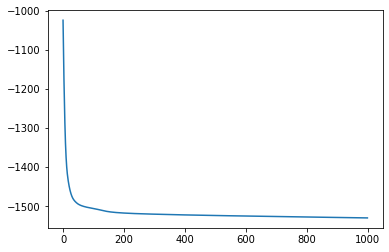

In [4]:
latent_model = LatentGPHeinonen
# latent_model = LatentGPDeltaInducing

# X_inducing = X[::10]
# X_inducing = jnp.linspace(0, 1, 10).reshape(-1, 1)
X_inducing = X
print(X_inducing.shape)

ell_model = latent_model(X_inducing, RBF(X_inducing, 0.2, 1.0).trainable(False), vmap=True)
sigma_model = latent_model(X_inducing, RBF(X_inducing, 0.2, 1.0).trainable(False), vmap=False)
likelihood_model = latent_model(X_inducing, RBF(X_inducing, 0.3, 1.0).trainable(False), vmap=False)

kernel = Gibbs(X_inducing, ell_model, sigma_model, flex_ell=True, flex_sigma=True)
likelihood = Heteroscedastic(likelihood_model)
gp = ExactGPRegression(kernel, likelihood, Average(), X_inducing=X_inducing)
gp.kernel.ell_model.reverse_init_latent(jnp.array(0.05))
gp.kernel.sigma_model.reverse_init_latent(jnp.array(0.3))
gp.likelihood.latent_model.reverse_init_latent(jnp.array(0.05))

print(gp.log_probability(X, y))

optimizer = optax.adam(learning_rate=0.01)
n_iters = 1000

def loss_fn(raw_params):
    gp.set_raw_parameters(raw_params)
    return -gp.log_probability(X, y)

raw_params = gp.get_raw_parameters()

# Manual
# value_fn = jax.jit(loss_fn)
# grad_fn = jax.jit(jax.grad(loss_fn))

# result = {"loss_history": [jnp.inf], "raw_params": None}

# step = jnp.array(1e-5)
# steps = []
# grads = grad_fn(raw_params)
# for iter in trange(n_iters):
#     old_params = raw_params
#     raw_params = jtu.tree_map(lambda x, g: x - step * g, raw_params, grads)
#     loss = value_fn(raw_params)
#     if loss >= result["loss_history"][-1]:
#         raw_params = old_params
#         step *= 0.7
#         result["loss_history"].append(result["loss_history"][-1])
#     else:
#         step *= 1.1
#         grads = grad_fn(raw_params)
#         result["loss_history"].append(loss)
#     steps.append(step)

# result["raw_params"] = raw_params

# result["loss_history"].pop(0)


# Automatic

result = train_fn(loss_fn, init_raw_params=raw_params, optimizer=optimizer, n_iters=n_iters)

plt.plot(result["loss_history"]);
result["loss_history"][-10:]

In [12]:
# wl_ell = result["raw_params"]['kernel']['ell_gp']['latent'].reshape(-1,1)
# wl_sigma  = result["raw_params"]['kernel']['sigma_gp']['latent'].reshape(-1,1)
# wl_omega = result["raw_params"]['likelihood']['latent_gp']['latent'].reshape(-1,1)

# savemat('wdt_wl.mat', {"wl": {'wl_ell': wl_ell, 'wl_sigma': wl_sigma, 'wl_omega': wl_omega}})

1536.1187844358542


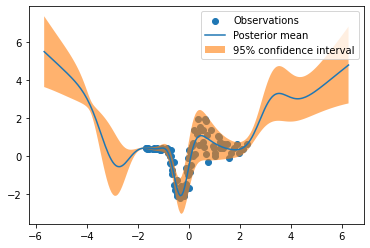

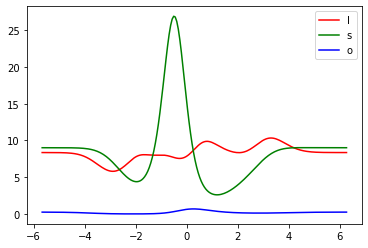

In [13]:
span = 1
X_test = jnp.linspace(0-span, 1+span, 200).reshape(-1, 1)
gp.set_raw_parameters(result["raw_params"])
print(gp.log_probability(X, y))
pred_mean, pred_cov = gp.predict(X, y, X_test, include_noise=False)
pred_ell = gp.kernel.ell_model(X_inducing)(X_test)
pred_sigma = gp.kernel.sigma_model(X_inducing)(X_test)
pred_omega = gp.likelihood.latent_model(X_inducing)(X_test)
pred_cov = add_to_diagonal(pred_cov, pred_omega**2, 0.0)
trained_X_inducing = gp.X_inducing()

(X_, X_test_, X_inducing_, trained_X_inducing_), (pred_mean_, y_), pred_ell_, pred_sigma_, pred_omega_ = scaler.inverse_transform((X, X_test, X_inducing, trained_X_inducing), (pred_mean, y), pred_ell, pred_sigma, pred_omega)
pred_cov_ = pred_cov * scaler.y_scale**2


ax = plot_posterior(X_, y_, X_test_, pred_mean_, pred_cov_, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));
# for x in X_inducing_:
#     ax.axvline(x, color="k", alpha=0.3)

# for x in trained_X_inducing_:
#     ax.axvline(x, color="r", alpha=0.3)


plt.figure();
plt.plot(X_test_, pred_ell_, label='l', color='r')
plt.plot(X_test_, pred_sigma_, label='s', color='g')
plt.plot(X_test_, pred_omega_, label='o', color='b');
plt.legend();